In [1]:


from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import pandas as pd
import re
from tqdm import tqdm

Загрузим подготовленный в предыдущем ноутбуке датасет

In [3]:
df_2014 = pd.read_csv('//content/drive/MyDrive/dataset_2014_corrected.csv')

In [5]:
df_2014 = df_2014.rename(columns={'docTypeByOP':'art',
                                  'textOCR':'text'} )
df_2014

,art,text
0,Договор,договор между российской федерацией и республи...
1,Постановление,правительство забайкальского края постановлени...
2,Распоряжение,правительство российской федерации распоряжени...
3,Постановление,а1истрация тамбовской области постановление ек...
4,Постановление,правительство рязанской области постановление ...
...,...,...
14516,Указ,указ президента российской федерации об атаман...
14517,Постановление,пр .итепьство как и про опьна 0 1801000 04 1 п...
14518,Распоряжение,правительство российской федерации распоряжени...
14519,Постановление,смоленская областная дума постановление от йй7...


Для красивой визуализации: сначала картинка со всеми словами из датасета

<Axes: >

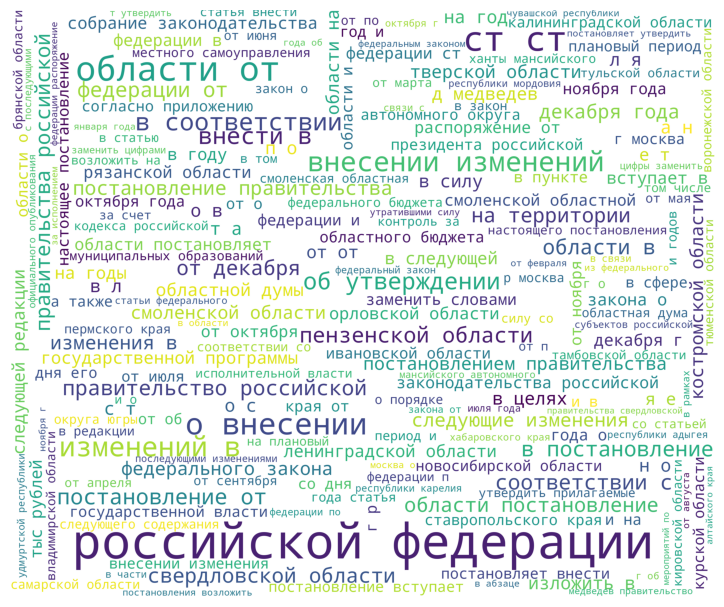

In [6]:


import matplotlib.pyplot as plt
%matplotlib inline


from wordcloud import WordCloud, STOPWORDS

def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus



# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud
corpus = get_corpus(df_2014['text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')

plt.subplot(1, 2, 1)

После удаления стоп-слов и слов, короче 3 символов (например, "ст")

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")

df_2014['text_token'] = df_2014['text'].map(lambda x: x.split(' '))
df_2014['text_token'] = df_2014['text_token'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                  and token != " "\
                                                                  and len(token)>3] )
df_2014['text_token'] = df_2014['text_token'].map(lambda x: ' '.join(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
corpus_clean = get_corpus(df_2014['text_token'].values)
procWordCloud = get_wordCloud(corpus_clean)

<Axes: >

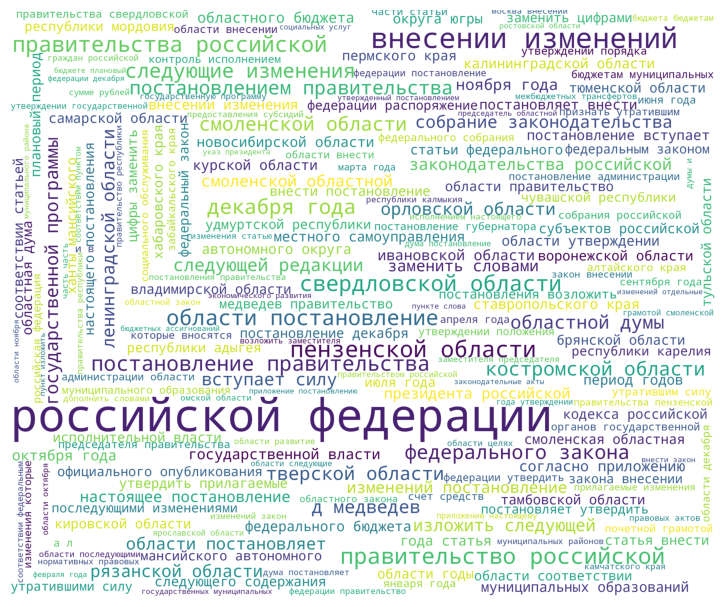

In [18]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')

plt.subplot(1, 2, 1)

Посмотрим на разбалансировку классов

In [19]:
distrib = pd.DataFrame(df_2014['art'].value_counts())
distrib

,art
Постановление,8378
Распоряжение,2676
Закон,1530
Указ,1047
Федеральный закон,535
Приказ,101
Соглашение,99
Областной закон,58
Определение,33
Протокол,23


Для данного датасета возьму только 5 классов для классификации - у остальных слишком маленькая репрезентативноть

In [20]:
df_2014_clas = df_2014.loc[df_2014['art'].isin(['Постановление', 'Распоряжение', 'Закон', 'Указ', 'Федеральный закон'])]

Попробуем классифицировать тексты классическими ML-алгоритмами: логистической регрессией и SGD

In [62]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV



Поделим выборку на трейн, тест и валидационный датасет

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(df_2014_clas['text_token'], df_2014_clas['art'], test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [51]:
params = {}

params['stop_words'] = stopwords.words('russian')
params['ngram_range'] = (1, 3)
params['min_df'] = 3


tfidf  = TfidfVectorizer(**params)
tfidf.fit([i for i in df_2014_clas['text_token']])

TfidfVectorizer(min_df=3, ngram_range=(1, 3),
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...])

In [52]:
X_train_t = tfidf.transform(X_train)
X_test_t = tfidf.transform(X_test)
X_valid_t = tfidf.transform(X_valid)

In [53]:
m_params = {}
m_params['solver'] = 'lbfgs'
m_params['multi_class'] = 'multinomial'

log_reg = LogisticRegression(**m_params)
log_reg.fit(X_train_t, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  "Only 'saga' solver supports elasticnet penalty, got solver={}.".format(


LogisticRegression(multi_class='multinomial')

In [56]:
predicted_log_reg = log_reg.predict(X_test_t)
print(metrics.classification_report(predicted_log_reg, y_test))

                   precision    recall  f1-score   support

            Закон       0.96      0.99      0.97       269
    Постановление       1.00      0.96      0.98      1547
     Распоряжение       0.95      0.99      0.97       455
             Указ       0.83      1.00      0.91       178
Федеральный закон       0.99      1.00      1.00       101

         accuracy                           0.97      2550
        macro avg       0.94      0.99      0.96      2550
     weighted avg       0.97      0.97      0.97      2550



In [58]:
predicted_log_reg_v = log_reg.predict(X_valid_t)
print(metrics.classification_report(predicted_log_reg_v, y_valid))

                   precision    recall  f1-score   support

            Закон       0.94      0.99      0.96       136
    Постановление       1.00      0.95      0.98       918
     Распоряжение       0.93      1.00      0.96       232
             Указ       0.83      1.00      0.91        83
Федеральный закон       0.98      1.00      0.99        48

         accuracy                           0.97      1417
        macro avg       0.94      0.99      0.96      1417
     weighted avg       0.97      0.97      0.97      1417



Не такие уж и плохие результаты для регрессии!


Теперь SGD

In [65]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))
])



sgd_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('sgd_clf', SGDClassifier(random_state=42))])

In [26]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

                   precision    recall  f1-score   support

            Закон       0.99      0.99      0.99       279
    Постановление       1.00      0.98      0.99      1504
     Распоряжение       0.97      0.99      0.98       464
             Указ       0.93      1.00      0.96       201
Федеральный закон       1.00      1.00      1.00       102

         accuracy                           0.99      2550
        macro avg       0.98      0.99      0.98      2550
     weighted avg       0.99      0.99      0.99      2550



In [28]:
parameters = {
              'sgd_clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'sgd_clf__class_weight':[None, 'balanced'],
              'sgd_clf__penalty':[None, 'l2', 'l1', 'elasticnet'],
              'tfidf__strip_accents':['ascii', 'unicode', None],
               'tfidf__ngram_range':[(1,2), (1,3), (1,4)]
              }
model = GridSearchCV(sgd_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train[:1000], y_train[:1000])

In [29]:
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)

Best score and parameter combination:
0.988 {'sgd_clf__class_weight': 'balanced', 'sgd_clf__loss': 'hinge', 'sgd_clf__penalty': 'l1', 'tfidf__ngram_range': (1, 4), 'tfidf__strip_accents': None}


In [68]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 4), strip_accents=None)),
    ('sgd_clf', SGDClassifier(loss='hinge',penalty='l1', class_weight='balanced', random_state=42))
])



In [31]:
sgd_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4))),
                ('sgd_clf',
                 SGDClassifier(class_weight='balanced', penalty='l1',
                               random_state=42))])

In [32]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

                   precision    recall  f1-score   support

            Закон       1.00      0.99      0.99       281
    Постановление       1.00      0.99      1.00      1483
     Распоряжение       0.99      0.99      0.99       472
             Указ       0.99      1.00      1.00       212
Федеральный закон       1.00      1.00      1.00       102

         accuracy                           0.99      2550
        macro avg       0.99      0.99      0.99      2550
     weighted avg       0.99      0.99      0.99      2550



In [33]:
predicted_sgd_val = sgd_ppl_clf.predict(X_valid)
print(metrics.classification_report(predicted_sgd_val, y_valid))

                   precision    recall  f1-score   support

            Закон       1.00      0.99      0.99       146
    Постановление       1.00      1.00      1.00       876
     Распоряжение       0.99      1.00      1.00       246
             Указ       1.00      1.00      1.00       100
Федеральный закон       1.00      1.00      1.00        49

         accuracy                           1.00      1417
        macro avg       1.00      1.00      1.00      1417
     weighted avg       1.00      1.00      1.00      1417



Подозрительно высокий результат